Based on the notes from http://cs231n.github.io/

#6 Neural Networks Part 2: Setting up the Data and the Loss 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread, imsave, imresize
%matplotlib inline

In [2]:
def load_CIFAR10(cifar10dir):
    import pickle
    files = ['data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
    with open(cifar10dir + 'data_batch_1', 'rb') as fo:
        db = pickle.load(fo, encoding='bytes')
        Xtr = db[b'data']
        Ytr = np.array(db[b'labels'], dtype=np.uint8)
    for file in files:
        with open(cifar10dir + file, 'rb') as fo:
            db = pickle.load(fo, encoding='bytes')
            Xtr = np.concatenate( ( Xtr, db[b'data'] ) )
            Ytr = np.concatenate( ( Ytr, np.array(db[b'labels'], dtype=np.uint8) ) )
    with open(cifar10dir + 'test_batch', 'rb') as fo:
        db = pickle.load(fo, encoding='bytes')
        Xte = db[b'data']
        Yte = np.array(db[b'labels'], dtype=np.uint8)
    
    Xtr = np.reshape(Xtr, (Xtr.shape[0],32, 32, 3), 'F')
    Xtr = np.swapaxes(Xtr, 1, 2)
    
    Xte = np.reshape(Xte, (Xte.shape[0],32, 32, 3), 'F')
    Xte = np.swapaxes(Xte, 1, 2)
    
    with open(cifar10dir + 'batches.meta', 'rb') as fo:
        meta = pickle.load(fo, encoding='bytes')
        labelNames = meta[b'label_names']
        for i in range(len(labelNames)):
            labelNames[i] = labelNames[i].decode("utf-8")
    
    
    return Xtr, Ytr, Xte, Yte, labelNames

In [3]:
Xtr, Ytr, Xte, Yte, labelNames = load_CIFAR10('cifar-10-batches-py/')

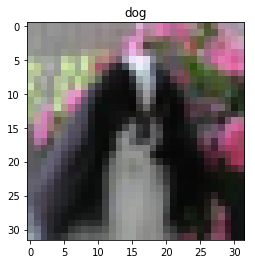

In [4]:
idx=42
plt.title(labelNames[Yte[idx]])
plt.imshow(Xte[idx])
plt.show()

In [5]:
Xtr_rows = Xtr.reshape(Xtr.shape[0], 32 * 32 * 3) # Xtr_rows becomes 50000 x 3072
Xte_rows = Xte.reshape(Xte.shape[0], 32 * 32 * 3) # Xte_rows becomes 10000 x 3072

In [6]:
# Assume input data matrix X of size [N x D]
Xtr_rows.dtype

dtype('uint8')

In [7]:
X_zc = Xtr_rows.astype(np.float)
X_zc -= np.mean(X_zc, axis = 0) # zero-center the data (important)
cov = np.dot(X_zc.T, X_zc) / X_zc.shape[0] # get the data covariance matrix

In [8]:
U,S,V = np.linalg.svd(cov)

In [9]:
U_img=np.copy(U.T)
U_img-=np.amin(U_img,axis=0)
U_img/=np.amax(U_img,axis=0)
U_img*=255
U_img=U_img.astype(np.uint8)
U_img=U_img.reshape(3072,32,32,3)

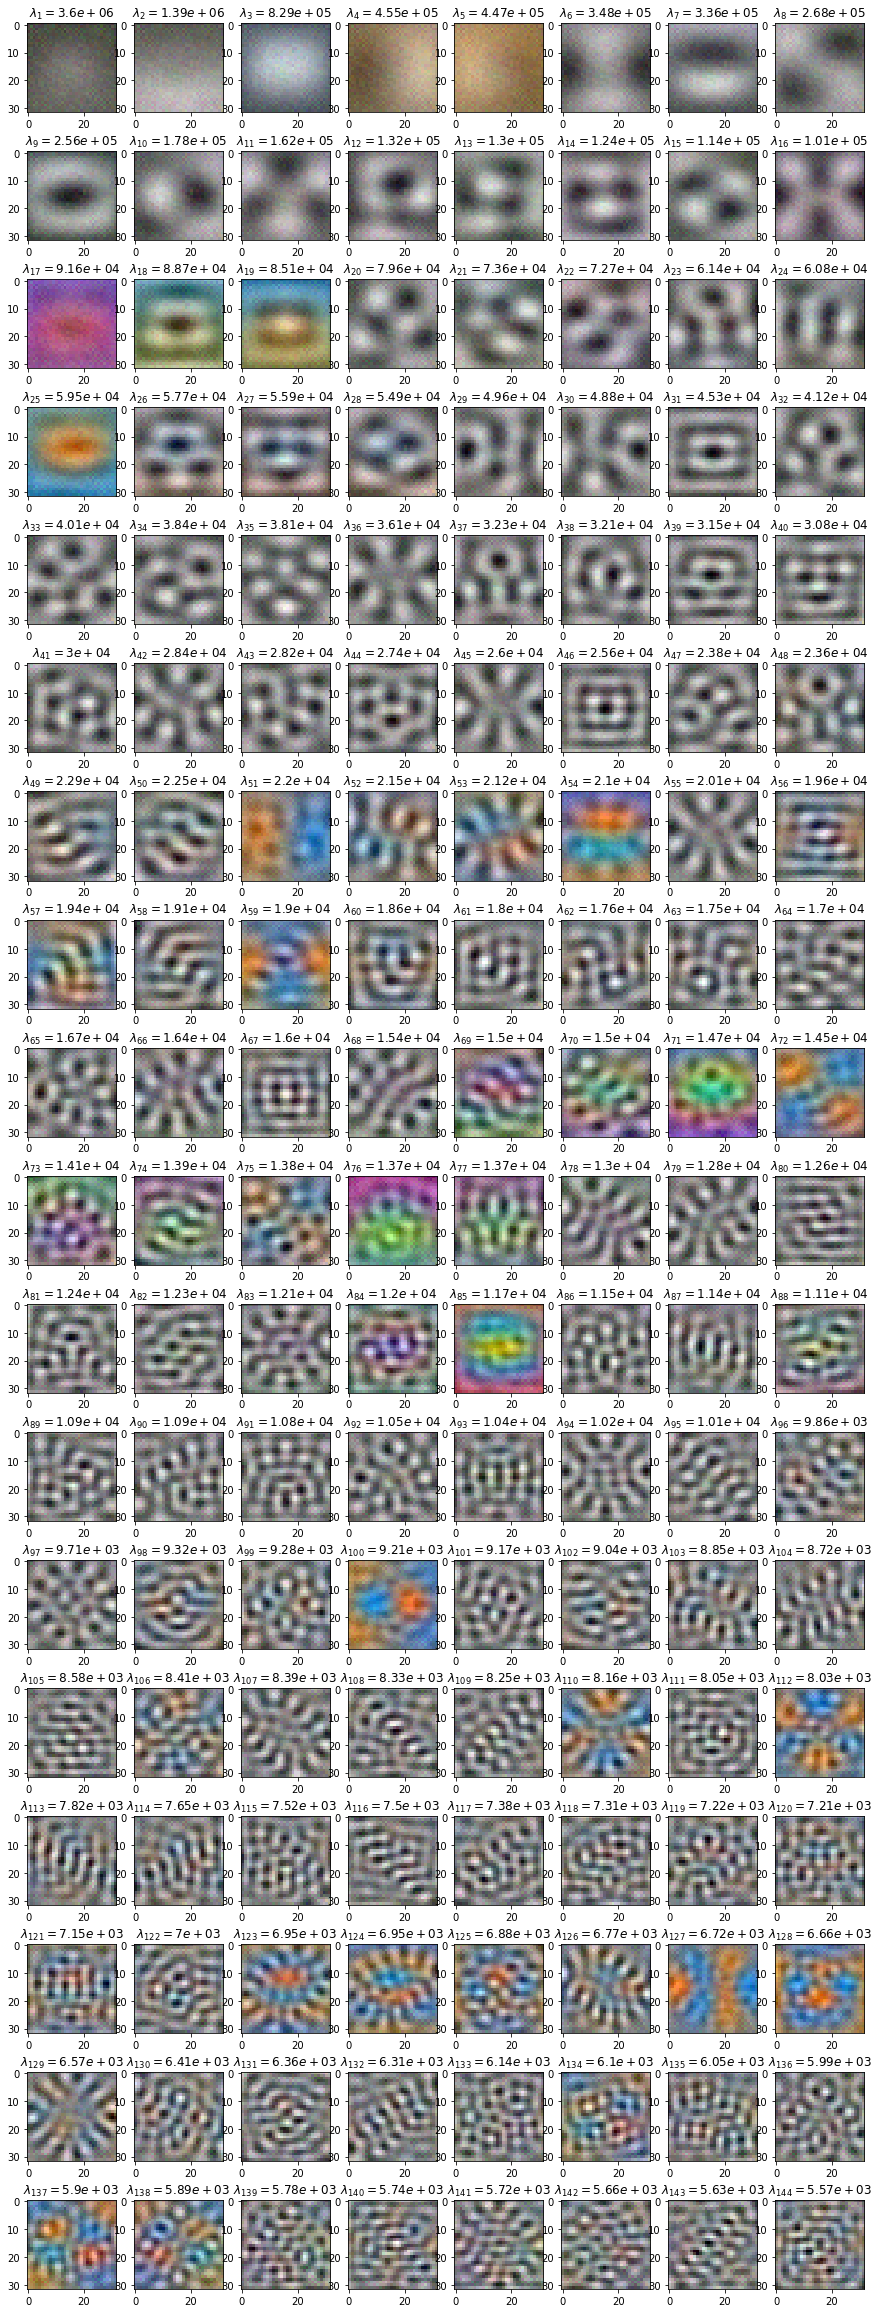

In [10]:
plt.figure(figsize=(15,42))
for idx in range(144):
    plt.subplot(18,8,idx+1)
    plt.title("$\lambda_{" + str(idx+1) + "}=" + "{0:0.3}".format(S[idx]) + "$")
    plt.imshow(U_img[idx])
    
# plt.tight_layout()
plt.show()

In [11]:
num_of_components = 144
U_small = U[:,:num_of_components]
V_small = V[:num_of_components,:]
S_small = S[:num_of_components]

In [12]:
Xtr_reduced = Xtr_rows.dot(U_small)
Xtr_reduced.shape

(50000, 144)

In [13]:
Xtr_red_img = Xtr_reduced.dot(U_small.T)

In [14]:
Xtr_red_img-=np.amin(Xtr_red_img,axis=0)
Xtr_red_img/=np.amax(Xtr_red_img,axis=0)
Xtr_red_img*=255
Xtr_red_img=Xtr_red_img.astype(np.uint8)
Xtr_red_img=Xtr_red_img.reshape(50000,32,32,3)

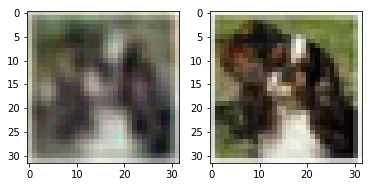

In [15]:
idx=500
plt.subplot(1,2,1)
plt.imshow(Xtr_red_img[idx])
plt.subplot(1,2,2)
plt.imshow(Xtr[idx])
plt.show()

#8 Putting it together: Minimal Neural Network Case Study

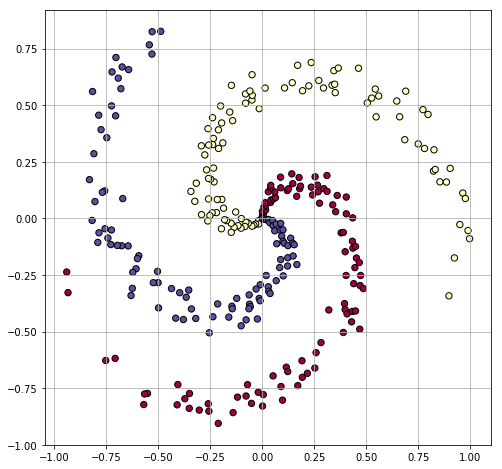

In [16]:
# Spiral dataset
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
# lets visualize the data:
plt.figure(figsize=(8,8))
plt.grid()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolors='0')
plt.show()

In [17]:
# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

In [18]:
# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

In [19]:
# gradient descent loop
num_examples = X.shape[0]
for i in range(200):

    # compute class scores for a linear classifier
    scores = np.dot(X, W) + b
    # avoid numeric instability
    scores -= np.max(scores)
    # get unnormalized probabilities
    exp_scores = np.exp(scores)
    # normalize them for each example
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    correct_logprobs = -np.log(probs[range(num_examples),y])

    # compute the loss: average cross-entropy loss and regularization
    data_loss = np.sum(correct_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W*W)
    loss = data_loss + reg_loss

    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples

    dW = np.dot(X.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)
    dW += reg*W # don't forget the regularization gradient

    # perform a parameter update
    W += -step_size * dW
    b += -step_size * db
    
    print('iter %d; loss is %f' % (i, loss), end='\r')

In [20]:
# evaluate training set accuracy
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.53


In [21]:
def lin_classifier(X):
    return np.dot(X, W) + b

In [22]:
def plot_scatter_and_classifier(X, classifier):
    h = 0.01  # step size in the mesh
    b = 0.2   # empty border width in plot
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - b, X[:, 0].max() + b
    y_min, y_max = X[:, 1].min() - b, X[:, 1].max() + b
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    mesh_scores=classifier(np.c_[xx.ravel(), yy.ravel()])
    Z = np.argmax(mesh_scores,axis=1)
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(8,8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolors='0')
    plt.xlim(x_min,x_max)
    plt.ylim(y_min,y_max)
    plt.show()

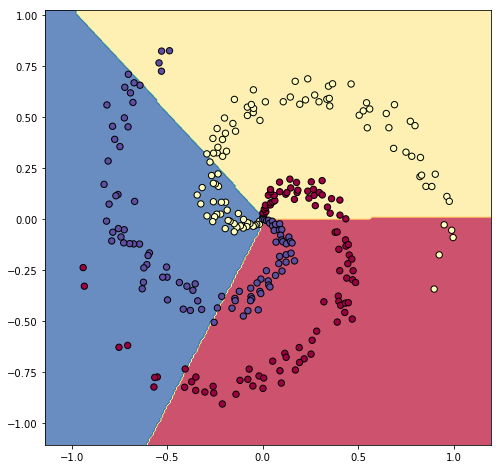

In [23]:
plot_scatter_and_classifier(X,lin_classifier)

nolearn.lasagne

In [24]:
import theano
import lasagne
from lasagne import layers
from lasagne.updates import sgd
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import BatchIterator
from nolearn.lasagne import TrainSplit

Using cuDNN version 6021 on context None
Mapped name None to device cuda0: GeForce GTX 1060 6GB (0000:01:00.0)


In [25]:
net2 = NeuralNet(
    layers=[('input', layers.InputLayer),
            ('output', layers.DenseLayer),
            ],
    # input layer(batch size, input dimensions)
    input_shape=(N,D),
    # output
    output_nonlinearity=lasagne.nonlinearities.softmax,
    output_W=lasagne.init.Uniform(range=(0,0.01)), 
    output_b=lasagne.init.Constant(0.),
    output_num_units=K,
    # optimization method params
    batch_iterator_train = BatchIterator(batch_size=N,shuffle=False),
    batch_iterator_test = BatchIterator(batch_size=N,shuffle=False),
    train_split = TrainSplit(eval_size=0.0),
    objective_loss_function = lasagne.objectives.categorical_crossentropy,
    objective_l2 = reg,
    update=sgd,
    update_learning_rate=step_size,
    max_epochs=200,
    verbose=1,
    )

In [26]:
nn = net2.fit(X,y)

# Neural Network with 9 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input        2
  1  output       3

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  -----
      1     1.44241         nan        nan          nan  0.00s
      2     1.35600         nan        nan          nan  0.00s
      3     1.28438         nan        nan          nan  0.00s
      4     1.22474         nan        nan          nan  0.00s
      5     1.17769         nan        nan          nan  0.00s
      6     1.14127         nan        nan          nan  0.00s
      7     1.11302         nan        nan          nan  0.00s
      8     1.09092         nan        nan          nan  0.00s
      9     1.07343         nan        nan          nan  0.00s
     10     1.05940         nan        nan          nan  0.00s
     11     1.04803         nan        nan          nan  0.00s
     12     1.03872         nan   

     99     0.98233         nan        nan          nan  0.00s
    100     0.98233         nan        nan          nan  0.00s
    101     0.98232         nan        nan          nan  0.00s
    102     0.98232         nan        nan          nan  0.00s
    103     0.98232         nan        nan          nan  0.00s
    104     0.98231         nan        nan          nan  0.00s
    105     0.98231         nan        nan          nan  0.00s
    106     0.98231         nan        nan          nan  0.00s
    107     0.98231         nan        nan          nan  0.00s
    108     0.98230         nan        nan          nan  0.00s
    109     0.98230         nan        nan          nan  0.00s
    110     0.98230         nan        nan          nan  0.00s
    111     0.98230         nan        nan          nan  0.00s
    112     0.98230         nan        nan          nan  0.00s
    113     0.98229         nan        nan          nan  0.00s
    114     0.98229         nan        nan          nan

In [27]:
from collections import OrderedDict

In [28]:
net2.get_all_params_values()

OrderedDict([('input', []),
             ('output', [array([[ 1.26761004,  1.3641036 , -2.62535623],
                      [-2.70688742,  3.07239278, -0.36165087]]),
               array([-0.32747553,  0.01942846,  0.30804707])])])

In [29]:
input_var = net2.layers_['input'].input_var
output_layer = layers.get_output(net2.layers_['output'], deterministic=True)
nl_lin_classifier = theano.function([input_var], output_layer)

In [30]:
# evaluate training set accuracy
scores = nl_lin_classifier(X)
predicted_class = np.argmax(scores, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.56


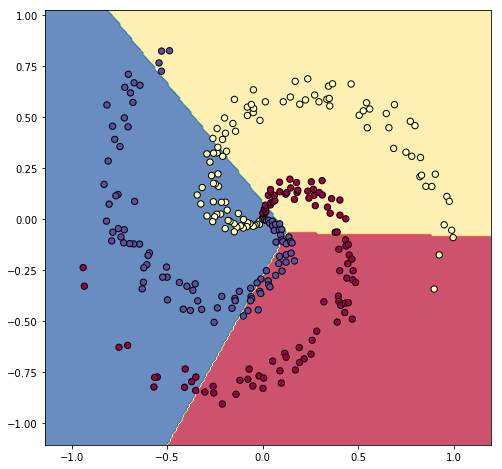

In [31]:
plot_scatter_and_classifier(X,nl_lin_classifier)

In [32]:
# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

In [33]:
# initialize parameters randomly
h = 100 # size of hidden layer
W1 = 0.01 * np.random.randn(D,h)
b1 = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

In [34]:
# gradient descent loop
num_examples = X.shape[0]
for i in range(10000):
    # evaluate class scores with a 2-layer Neural Network
    hidden_layer = np.maximum(0, np.dot(X, W1) + b1) # note, ReLU activation
    scores = np.dot(hidden_layer, W2) + b2

    # avoid numeric instability
    scores -= np.max(scores)
    # get unnormalized probabilities
    exp_scores = np.exp(scores)
    # normalize them for each example
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    correct_logprobs = -np.log(probs[range(num_examples),y])

    # compute the loss: average cross-entropy loss and regularization
    data_loss = np.sum(correct_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W1*W1)
    loss = data_loss + reg_loss

    # compute the gradient on scores
    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples

    # backpropate the gradient to the parameters
    # first backprop into parameters W2 and b2
    dW2 = np.dot(hidden_layer.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)

    # next backprop into hidden layer
    dhidden = np.dot(dscores, W2.T)

    # backprop the ReLU non-linearity
    dhidden[hidden_layer <= 0] = 0

    # finally into W,b
    dW1 = np.dot(X.T, dhidden)
    db1 = np.sum(dhidden, axis=0, keepdims=True)

    # add regularization gradient contribution
    dW2 += reg * W2
    dW1 += reg * W1

    # perform a parameter update
    W1 += -step_size * dW1
    b1 += -step_size * db1
    W2 += -step_size * dW2
    b2 += -step_size * db2
    
    print('iter %d; loss is %f' % (i, loss), end='\r')

In [35]:
# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W1) + b1)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.98


In [36]:
def NN_classifier(X):
    hidden_layer = np.maximum(0, np.dot(X, W1) + b1) # note, ReLU activation
    return np.dot(hidden_layer, W2) + b2

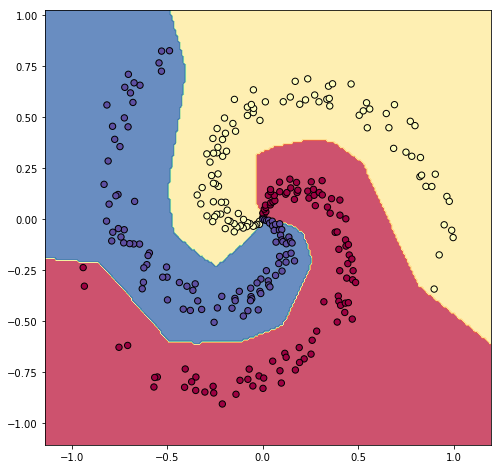

In [37]:
plot_scatter_and_classifier(X,NN_classifier)

In [38]:
from nolearn.lasagne import BatchIterator
from nolearn.lasagne import TrainSplit

In [39]:
net3 = NeuralNet(
    layers=[('input', layers.InputLayer),
            ('hidden', layers.DenseLayer),
            ('output', layers.DenseLayer),
            ],
    # input layer(batch size, input dimensions)
    input_shape=(N,D),
    # hidden
    hidden_nonlinearity=lasagne.nonlinearities.rectify,
    hidden_W=lasagne.init.Uniform(range=(0,0.01)), 
    hidden_b=lasagne.init.Constant(0.),
    hidden_num_units=h,
    # output
    output_nonlinearity=lasagne.nonlinearities.softmax,
    output_W=lasagne.init.Uniform(range=(0,0.01)), 
    output_b=lasagne.init.Constant(0.),
    output_num_units=K,
    # optimization method params
    batch_iterator_train = BatchIterator(batch_size=N,shuffle=False),
    batch_iterator_test = BatchIterator(batch_size=N,shuffle=False),
    train_split = TrainSplit(eval_size=0.0),
    objective_loss_function = lasagne.objectives.categorical_crossentropy,
    objective_l2 = reg,
    update=sgd,
    update_learning_rate=step_size,
    max_epochs=10000,
    verbose=0,
    )

In [40]:
nn = net3.fit(X,y)

In [41]:
input_var = net3.layers_['input'].input_var
output_layer = layers.get_output(net3.layers_['output'], deterministic=True)
nl_NN_classifier = theano.function([input_var], output_layer)

In [42]:
# evaluate training set accuracy
scores = nl_NN_classifier(X)
predicted_class = np.argmax(scores, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.91


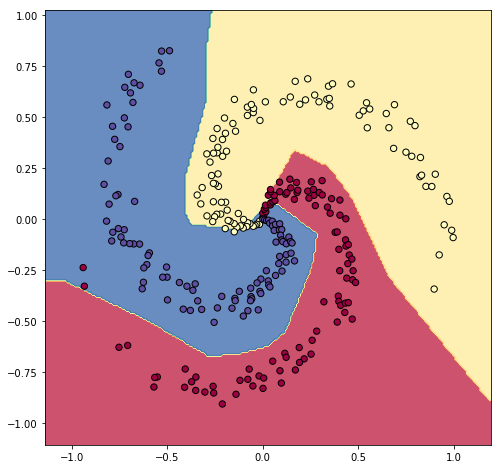

In [43]:
plot_scatter_and_classifier(X,nl_NN_classifier)